In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc


In [3]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
news_df = pd.read_csv('train.csv')

In [5]:
news_df = news_df.fillna(' ')

In [6]:
news_df['content'] = news_df['tweet']

In [7]:
# Stemming function
ps = PorterStemmer()
def stemming(content):
    content = re.sub('[^a-zA-Z]', ' ', content)
    content = content.lower()
    content = content.split()
    content = [ps.stem(word) for word in content if word not in stopwords.words('english')]
    return ' '.join(content)

In [8]:
# Apply stemming
news_df['content'] = news_df['content'].apply(stemming)

In [12]:
X = news_df['content'] # Features (raw text data)
y = news_df["label"]  # Labels (0 = Real, 1 = Fake)

In [13]:

# Initialize TF-IDF Vectorizer instead of CountVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(X)

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)


In [15]:
# Initialize models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

In [16]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Display Metrics
    print(f"\n===== {name} Model Evaluation =====")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()



Training Naive Bayes model...

===== Naive Bayes Model Evaluation =====
Accuracy: 95.28%
Precision: 91.95%
Recall: 35.71%
F1-Score: 51.45%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      5945
           1       0.92      0.36      0.51       448

    accuracy                           0.95      6393
   macro avg       0.94      0.68      0.74      6393
weighted avg       0.95      0.95      0.94      6393



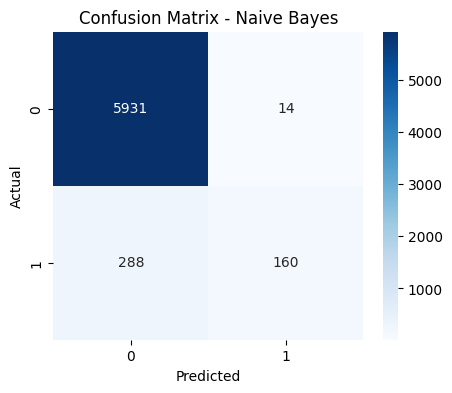

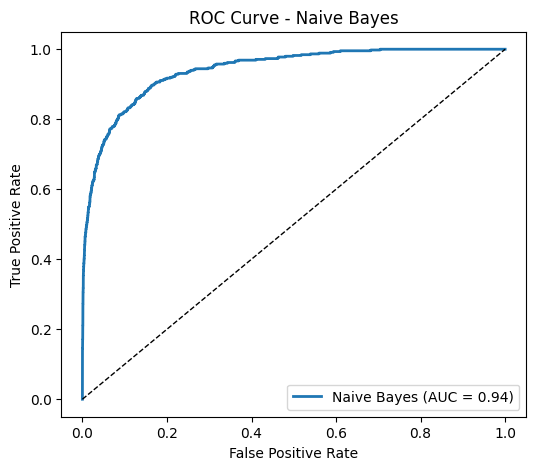


Training Logistic Regression model...

===== Logistic Regression Model Evaluation =====
Accuracy: 95.18%
Precision: 89.33%
Recall: 35.49%
F1-Score: 50.80%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      5945
           1       0.89      0.35      0.51       448

    accuracy                           0.95      6393
   macro avg       0.92      0.68      0.74      6393
weighted avg       0.95      0.95      0.94      6393



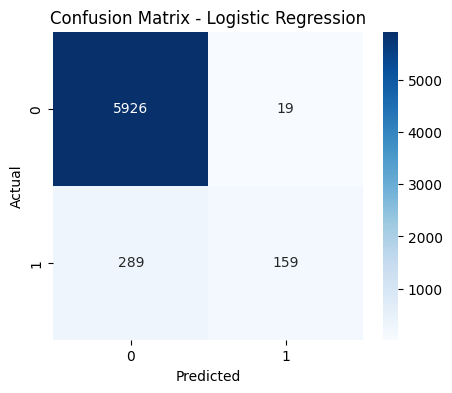

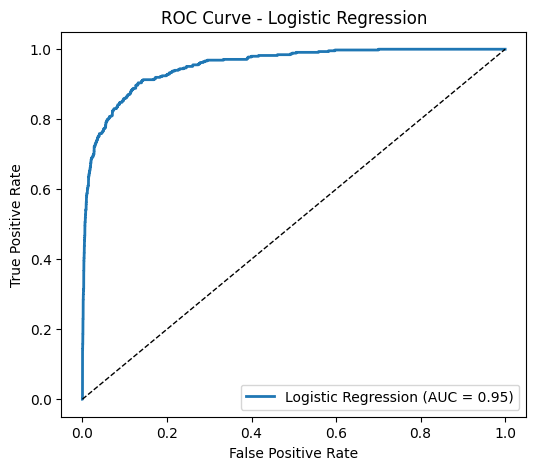


Training Random Forest model...


In [ ]:
# Train and evaluate each model
trained_models = {}
for name, model in models.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train)  # Train model
    evaluate_model(name, model, X_train, X_test, y_train, y_test)
    trained_models[name] = model  # Store trained model


In [ ]:
# ==========================
def predict_news(news_text, model_name):
    if model_name not in trained_models:
        print("Model not trained yet!")
        return

    # Preprocess input text
    processed_text = stemming(news_text)
    input_vector = vectorizer.transform([processed_text])

    # Predict using selected model
    model = trained_models[model_name]
    prediction = model.predict(input_vector)

    # Display result
    if prediction[0] == 1:
        print(f"🛑 [Prediction using {model_name}]: **Fake News**")
    else:
        print(f"✅ [Prediction using {model_name}]: **Real News**")

# Test the prediction system
test_news = "Breaking news: This is an example of a tweet that needs classification!"
predict_news(test_news, "Naive Bayes")
predict_news(test_news, "Logistic Regression")
predict_news(test_news, "Random Forest")
predict_news(test_news, "SVM")